In [ ]:
!pip install yfinance pandas numpy matplotlib scikit-learn cvxpy

In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf
import cvxpy as cp
import yfinance as yf
import pandas as pd

In [14]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
data = yf.download(tickers, start='2020-01-01', end='2025-01-01', auto_adjust=True)['Close']

# Flatten column names if necessary
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(1)

# Calculate daily returns
returns = data.pct_change().dropna()
returns.head()

[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2020-01-03,-0.009722,-0.012139,-0.005231,-0.012452,0.029633
2020-01-06,0.007968,0.014886,0.026654,0.002585,0.019255
2020-01-07,-0.004703,0.002092,-0.001932,-0.009118,0.038801
2020-01-08,0.016086,-0.007809,0.007118,0.015929,0.049205
2020-01-09,0.021241,0.004799,0.010498,0.012493,-0.021945


In [16]:
# Traditional sample covariance matrix
sample_cov = returns.cov()

# Use Ledoit-Wolf shrinkage for better covariance estimate
lw = LedoitWolf()
lw_cov = lw.fit(returns).covariance_

In [18]:
# Expected returns and covariance matrix
mu = returns.mean().values
Sigma = lw_cov
n = len(mu)

# Optimization variables
w = cp.Variable(n)

# Constraints: weights sum to 1, no short-selling
constraints = [cp.sum(w) == 1, w >= 0]

# Minimize portfolio variance
portfolio_variance = cp.quad_form(w, Sigma)
objective = cp.Minimize(portfolio_variance)

# Solve the problem
prob = cp.Problem(objective, constraints)
prob.solve()

# Optimized weights
weights = w.value
portfolio = pd.Series(weights, index=tickers)
portfolio

AAPL     3.206598e-01
MSFT     1.307287e-01
GOOGL    2.399121e-01
AMZN     3.086994e-01
TSLA     5.435594e-20
dtype: float64

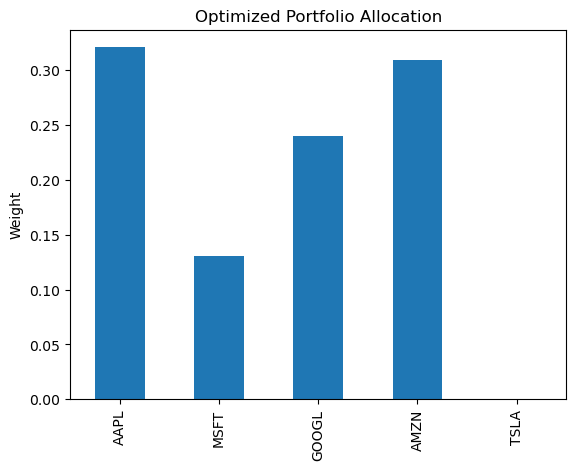

In [20]:
portfolio.plot(kind='bar', title='Optimized Portfolio Allocation')
plt.ylabel('Weight')
plt.show()